# Загрузка модулей и библиотек

In [1]:
!pip install statsmodels
!pip install scipy
#!pip install hurst
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import welch
#from scipy.signal.windows import hanning
from scipy.signal.windows import blackman

from pmdarima.arima.utils import ndiffs
import matplotlib.dates as mdates
#from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from matplotlib.dates import HourLocator, MinuteLocator
from matplotlib.ticker import AutoMinorLocator

# Загрузка исходных данных

In [3]:
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving 14_2024-03-05_2024-09-05.xlsx to 14_2024-03-05_2024-09-05.xlsx


Saving 14_2024-09-05_2025-03-05.xlsx to 14_2024-09-05_2025-03-05.xlsx


In [4]:
# Читаем данные из первого листа файла Excel
df_1 = pd.read_excel('/content/14_2024-03-05_2024-09-05.xlsx', engine='openpyxl')
df_2 = pd.read_excel('/content/14_2024-09-05_2025-03-05.xlsx', engine='openpyxl')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685201 entries, 0 to 685200
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           685201 non-null  int64         
 1   archive_itemid  685201 non-null  int64         
 2   source_time     685201 non-null  datetime64[ns]
 3   value           685201 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 20.9 MB


In [5]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686976 entries, 0 to 686975
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   layer           686976 non-null  int64         
 1   archive_itemid  686976 non-null  int64         
 2   source_time     686976 non-null  datetime64[ns]
 3   value           686976 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 21.0 MB


In [6]:
# Объединение двух датафреймов
df = pd.concat([df_1, df_2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372177 entries, 0 to 1372176
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1372177 non-null  int64         
 1   archive_itemid  1372177 non-null  int64         
 2   source_time     1372177 non-null  datetime64[ns]
 3   value           1372177 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 41.9 MB


In [7]:
# Читаем данные из первого листа файла Excel
#df = pd.read_excel('/content/14_2024-03-05_2024-09-05.xlsx', engine='openpyxl')

# Проверяем, существует ли колонка source_time
if 'source_time' in df.columns:
    # Преобразовываем source_time в объект datetime
    df['source_time'] = pd.to_datetime(df['source_time'])

    # Разделяем source_time на дату и время
    df['date'] = df['source_time'].dt.date
    df['time'] = df['source_time'].dt.time

    # Преобразуем time, чтобы отбросить секунды
    df['time'] = df['time'].apply(lambda t: t.replace(second=0))

# Показываем первые пять строк для проверки
print(df.head())

   layer  archive_itemid         source_time  value        date      time
0      1              14 2024-03-05 12:04:31    332  2024-03-05  12:04:00
1      1              14 2024-03-05 12:04:59    335  2024-03-05  12:04:00
2      1              14 2024-03-05 12:05:00    334  2024-03-05  12:05:00
3      1              14 2024-03-05 12:05:05    340  2024-03-05  12:05:00
4      1              14 2024-03-05 12:05:59    294  2024-03-05  12:05:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372177 entries, 0 to 1372176
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   layer           1372177 non-null  int64         
 1   archive_itemid  1372177 non-null  int64         
 2   source_time     1372177 non-null  datetime64[ns]
 3   value           1372177 non-null  int64         
 4   date            1372177 non-null  object        
 5   time            1372177 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 62.8+ MB


In [9]:
# Группируем данные по дате и времени (минуты), выбираем строку с минимальной секундой
df_grouped = df.sort_values(by=['source_time']) \
               .groupby(['date', 'time'], as_index=False) \
               .first()

# Показываем результат
print(df_grouped.head())
print(len(df_grouped))
df_grouped.info()

         date      time  layer  archive_itemid         source_time  value
0  2024-03-05  12:04:00      1              14 2024-03-05 12:04:31    332
1  2024-03-05  12:05:00      1              14 2024-03-05 12:05:00    334
2  2024-03-05  12:06:00      1              14 2024-03-05 12:06:00    295
3  2024-03-05  12:07:00      1              14 2024-03-05 12:07:00    160
4  2024-03-05  12:08:00      1              14 2024-03-05 12:08:00    167
427440
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427440 entries, 0 to 427439
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            427440 non-null  object        
 1   time            427440 non-null  object        
 2   layer           427440 non-null  int64         
 3   archive_itemid  427440 non-null  int64         
 4   source_time     427440 non-null  datetime64[ns]
 5   value           427440 non-null  int64         
dtypes: datetim

In [10]:
# Определяем минимальную и максимальную даты
min_date = df_grouped['date'].min()
max_date = df_grouped['date'].max()

# Генерируем все возможные даты между min_date и max_date
dates = pd.date_range(min_date, max_date, freq='D')

# Генерируем все возможные минуты в течение дня
minutes = pd.date_range('00:00', '23:59', freq='min').time

# Создаем DataFrame с полными датами и минутами
df_base = pd.DataFrame({
    'date': np.repeat(dates, len(minutes)),
    'time': np.tile(minutes, len(dates))
})

# Преобразуем time в формат HH:MM
df_base['time'] = df_base['time'].astype(str).str.slice(0, 5)

df_base.info()
print(len(df_base))
print(min_date)
print(max_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    527040 non-null  datetime64[ns]
 1   time    527040 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.0+ MB
527040
2024-03-05
2025-03-05


In [11]:
# Преобразуем столбец 'date' в df_base в формат datetime64[ns]
df_base['date'] = pd.to_datetime(df_base['date'])

# Преобразуем столбец 'date' в df_grouped в формат datetime64[ns]
df_grouped['date'] = pd.to_datetime(df_grouped['date'])

# Приводим столбец 'time' в df_base к формату 'HH:MM'
df_base['time'] = df_base['time'].str.slice(0, 5)

# Приводим столбец 'time' в df_grouped к формату 'HH:MM'
df_grouped['time'] = df_grouped['time'].astype(str).str.slice(0, 5)

# Объединяем df_base с df_grouped по дате и времени
result_df = df_base.merge(df_grouped, how='left', on=['date', 'time'])

# Заполняем пропущенные значения value, перенося последние известные значения вперед
#result_df['value'] = result_df['value'].fillna(method='ffill')

# Линейная интерполяция для заполнения пропущенных значений value
result_df['value'] = result_df['value'].interpolate()

# Показываем результат
print(result_df.head())
result_df.info()
print(len(result_df))

        date   time  layer  archive_itemid source_time  value
0 2024-03-05  00:00    NaN             NaN         NaT    NaN
1 2024-03-05  00:01    NaN             NaN         NaT    NaN
2 2024-03-05  00:02    NaN             NaN         NaT    NaN
3 2024-03-05  00:03    NaN             NaN         NaT    NaN
4 2024-03-05  00:04    NaN             NaN         NaT    NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            527040 non-null  datetime64[ns]
 1   time            527040 non-null  object        
 2   layer           427440 non-null  float64       
 3   archive_itemid  427440 non-null  float64       
 4   source_time     427440 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 24.1+ MB
527040


In [13]:
#  Удаляем NaN
result_df_no_na = result_df.dropna(subset=['value'])
# Показываем результат
print(result_df_no_na.head())
result_df_no_na.info()
print(len(result_df_no_na))

          date   time  layer  archive_itemid         source_time  value
724 2024-03-05  12:04    1.0            14.0 2024-03-05 12:04:31  332.0
725 2024-03-05  12:05    1.0            14.0 2024-03-05 12:05:00  334.0
726 2024-03-05  12:06    1.0            14.0 2024-03-05 12:06:00  295.0
727 2024-03-05  12:07    1.0            14.0 2024-03-05 12:07:00  160.0
728 2024-03-05  12:08    1.0            14.0 2024-03-05 12:08:00  167.0
<class 'pandas.core.frame.DataFrame'>
Index: 526316 entries, 724 to 527039
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            526316 non-null  datetime64[ns]
 1   time            526316 non-null  object        
 2   layer           427440 non-null  float64       
 3   archive_itemid  427440 non-null  float64       
 4   source_time     427440 non-null  datetime64[ns]
 5   value           526316 non-null  float64       
dtypes: datetime64[ns](2), float64(3)

# Функции для проведения статистического анализа

Функции для проведения анализа

In [14]:
# Функция для фильтрации данных по дате
def filter_by_date(result_df, start_date, end_date):
    mask = (result_df['date'] >= start_date) & (result_df['date'] <= end_date)
    filtered_df = result_df.loc[mask]
    return filtered_df




#def calculate_hurst_exponent(time_series, max_lag=50):
    """Рассчитывает показатель Херста с использованием R/S-анализа."""
#    lags = range(2, max_lag)
#    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
#    poly = np.polyfit(np.log(lags), np.log(tau), 1)
#    hurst = poly[0]*2
#    return hurst

def calculate_hurst_exponent(time_series, max_lag=50):
    """Рассчитывает показатель Херста с использованием R/S-анализа."""
    if len(time_series) < 2:
        return np.nan  # Возвращаем NaN, если длина ряда недостаточна

    lags = range(1, max_lag)
    tau = []
    for lag in lags:
        diff = np.subtract(time_series[lag:], time_series[:-lag])
        std_diff = np.std(diff)
        if std_diff != 0:
            tau.append(np.sqrt(std_diff))
        else:
            tau.append(0)

    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0] * 2
    return hurst


# Функция для расчёта основных статистик
def calculate_statistics(filtered_df):
    statistics = {}
    statistics['Количество данных в выборке'] = filtered_df['value'].count()
    statistics['Математическое ожидание'] = filtered_df['value'].mean()
    statistics['Медиана'] = filtered_df['value'].median()
    statistics['Максимальное значение'] = filtered_df['value'].max()
    statistics['Минимальное значение'] = filtered_df['value'].min()
    statistics['Дисперсия'] = filtered_df['value'].var()
    statistics['Среднее квадратичное отклонение'] = filtered_df['value'].std()
    statistics['Асимметрия'] = filtered_df['value'].skew()
    statistics['Эксцесс'] = filtered_df['value'].kurtosis()
    statistics['Квантили'] = filtered_df['value'].quantile([0.25, 0.5, 0.75]).to_dict()
    statistics['Коэффициент автокорреляции'] = filtered_df['value'].autocorr(lag=1)

    # Расчёт показателя Херста
    #values = filtered_df['value'].values
    #statistics['Показатель Херста'] = hurst.compute_Hc(values)

    values = filtered_df['value'].values
    statistics['Показатель Херста'] = calculate_hurst_exponent(values)

    return statistics

# Функция для построения гистограммы
def plot_histogram(filtered_df):
    plt.figure(figsize=(10, 6))
    #plt.hist(filtered_df['value'], bins=100)
    plt.hist(filtered_df['value'], bins=range(int(result_df['value'].min()), int(result_df['value'].max()) + 5, 5))
    plt.title("Гистограмма распредения")
    plt.xlabel("Значения")
    plt.ylabel("Частота")
    plt.grid(True)
    plt.show()

# Функция для построения графиков ACF и PACF
def plot_acf_pacf(filtered_df):
    n = len(filtered_df['value'])
    max_lags = int(np.sqrt(n))  # Подбор количества лагов согласно правилу Бартлетта

    print(f"Максимальный лаг: {max_lags}")

    plt.figure(figsize=(10, 6))
    plot_acf(filtered_df['value'], lags=max_lags, title='Автокорреляционная функция (АКФ)', zero=False)
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(filtered_df['value'], lags=max_lags, title='Частная корреляционная функция (ЧКФ)', zero=False)
    plt.show()


# Функция для построения графика спектральной плотности
def plot_spectral_density(result_df, start_date_str, end_date_str):
    # Преобразование строк в объекты datetime
    #start_date = pd.to_datetime(start_date_str, format='%d.%m.%Y')
    #end_date = pd.to_datetime(end_date_str, format='%d.%m.%Y')

    # Фильтрация данных по дате
    filtered_df = result_df[(result_df['date'] >= start_date) & (result_df['date'] <= end_date)]

    # Выбор временного ряда для анализа
    values = filtered_df['value'].values

    # Параметры для оценки спектральной плотности
    fs = 1  # Частота дискретизации (здесь 1, так как это временной ряд)
    nperseg = len(values) // 2  # Размер сегмента (зависит от длины ряда)
    window = blackman(nperseg)  # Применение оконной функции Blackman

    # Оцениваем спектральную плотность мощности с помощью метода Welch
    frequencies, psd = welch(values, fs=fs, nperseg=nperseg, window=window)

    # Построение графика спектральной плотности
    plt.figure(figsize=(10, 6))
    plt.semilogy(frequencies, psd, color='b')  # Логарифмическая шкала для оси Y
    plt.xlim(0, frequencies.max())  # Ограничиваем ось X
    plt.title(f'График сперктральной плотности')
    plt.xlabel('Частота [Гц]')
    plt.ylabel('Спектор мощности')
    plt.grid(True)
    plt.autoscale(enable=True, axis='both', tight=None)  # Автоматическое масштабирование осей
    plt.show()

In [15]:
# Функция для построения графика по дням
def plot_days(filtered_df, x_column="date", y_column="value", mode="mean"):
    """ Функция для построения графика по дням. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего значения по оси X. :param y_column: Название столбца, содержащего значения по оси Y. :param mode: Режим выбора значения ('min', 'max', 'mean'), по умолчанию 'mean'. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Устанавливаем index как DatetimeIndex
    filtered_df.set_index(x_column, inplace=True)

    # Группировка данных по дням и применение выбранного режима
    grouped_data = filtered_df.resample(rule='D')[y_column].agg(mode)

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Рисуем точки
    ax.scatter(grouped_data.index, grouped_data, color='blue', label=f"{y_column} (точки)")

    # Соединяем точки линиями
    ax.plot(grouped_data.index, grouped_data, color='black', label=f"{y_column} (линия)", linewidth=1)

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}) по дням")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Форматируем метки дат на оси X
    date_formatter = mdates.DateFormatter('%d.%m.%Y')  # Формат 'День.Месяц.Год'
    ax.xaxis.set_major_formatter(date_formatter)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

# Функция для построения графика по часам
def plot_hours(filtered_df, x_column="time", y_column="value", mode="max"):
    """ Функция для построения графика по часам. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего время. :param y_column: Название столбца, содержащего значения. :param mode: Режим отображения значений ('max', 'min', 'mean'), по умолчанию 'max'. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Устанавливаем index как DatetimeIndex
    filtered_df.set_index(x_column, inplace=True)

    # Группировка данных по времени и применение выбранного режима
    grouped_data = filtered_df.resample(rule='min')[y_column].agg(mode)

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Устанавливаем белый фон для всей фигуры
    fig.patch.set_facecolor('white')

    # Устанавливаем белый фон для области осей
    ax.patch.set_facecolor('white')

    # Рисуем маленькие точки
    ax.scatter(grouped_data.index, grouped_data, s=5, color='#007acc', label=f"{y_column} ({mode.capitalize()})")

    # Соединяем точки тонкой голубой линией
    ax.plot(grouped_data.index, grouped_data, color='#99ccff', linewidth=1, label=f"{y_column} (линия)")

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}, режим: {mode.capitalize()})")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Устанавливаем часовой локатор для меток времени
    ax.xaxis.set_major_locator(HourLocator(interval=1))  # Метки ровно по часам

    # Устанавливаем минутный локатор для мелких меток
    ax.xaxis.set_minor_locator(MinuteLocator(byminute=[0, 15, 30, 45]))  # Мелкие метки каждые 15 минут

    # Форматируем метки времени на оси X
    time_formatter = mdates.DateFormatter('%H:%M')  # Формат 'Часы:Минуты'
    ax.xaxis.set_major_formatter(time_formatter)

    # Уменьшаем размер шрифта меток на оси X
    ax.tick_params(axis='x', labelsize=8)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

In [16]:
def plot_hours(filtered_df,  selected_date, x_column="time", y_column="value", mode="max"):
    """ Функция для построения графика по часам. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего время. :param y_column: Название столбца, содержащего значения. :param mode: Режим отображения значений ('max', 'min', 'mean'), по умолчанию 'max'. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Преобразуем столбец time в формат времени
    filtered_df.loc[:, 'time'] = pd.to_datetime(filtered_df['time'], format='%H:%M')

    # Устанавливаем index как DatetimeIndex
    filtered_df.set_index(x_column, inplace=True)

    # Группировка данных по минутам и применение выбранного режима
    grouped_data = filtered_df.resample(rule='min')[y_column].agg(mode)

    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Устанавливаем белый фон для всей фигуры
    fig.patch.set_facecolor('white')

    # Устанавливаем белый фон для области осей
    ax.patch.set_facecolor('white')

    # Рисуем маленькие точки
    ax.scatter(grouped_data.index, grouped_data, s=5, color='#007acc', label=f"{y_column} ({mode.capitalize()})")

    # Соединяем точки тонкой голубой линией
    ax.plot(grouped_data.index, grouped_data, color='#99ccff', linewidth=1, label=f"{y_column} (линия)")

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}, режим: {mode.capitalize()})")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Устанавливаем часовой локатор для меток времени
    ax.xaxis.set_major_locator(HourLocator(interval=1))  # Метки ровно по часам

    # Устанавливаем минутный локатор для мелких меток
    ax.xaxis.set_minor_locator(MinuteLocator(byminute=range(0, 60, 10)))  # Мелкие метки каждые 10 минут

    # Форматируем метки времени на оси X, отображая только часы
    time_formatter = mdates.DateFormatter('%H')  # Формат 'Только часы'
    ax.xaxis.set_major_formatter(time_formatter)

    # Уменьшаем размер шрифта меток на оси X
    ax.tick_params(axis='x', labelsize=8)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

In [44]:
# Функция для построения графика по часам
def plot_selected_interval(filtered_df, selected_date, x_column="time", y_column="value"):
    """ Функция для построения графика по часам. :param filtered_df: Датафрейм Pandas с временным рядом. :param x_column: Название столбца, содержащего время. :param y_column: Название столбца, содержащего значения. """
    # Проверяем, что датафрейм не пустой
    if filtered_df.empty:
        print("Нет данных для построения графика.")
        return

    # Устанавливаем index как DatetimeIndex
    filtered_df.set_index(x_column, inplace=True)


    # Создаем фигуру и оси для графика
    fig, ax = plt.subplots(figsize=(12, 6))

    # Устанавливаем белый фон для всей фигуры
    fig.patch.set_facecolor('white')

    # Устанавливаем белый фон для области осей
    ax.patch.set_facecolor('white')

    # Рисуем маленькие точки
    ax.scatter(filtered_df.index, filtered_df[y_column], s=5, color='#007acc', label=f"{y_column} (точки)")

    # Соединяем точки тонкой голубой линией
    ax.plot(filtered_df.index, filtered_df[y_column], color='#99ccff', linewidth=1, label=f"{y_column} (линия)")

    # Настраиваем метки осей и заголовок
    ax.set_title(f"Построение графика ({y_column}) за {selected_date}")
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

    # Включаем сетку для удобства чтения графика
    ax.grid(True)

    # Устанавливаем часовой локатор для меток времени
    ax.xaxis.set_major_locator(HourLocator(interval=1))  # Метки ровно по часам

    # Устанавливаем минутный локатор для мелких меток
    ax.xaxis.set_minor_locator(MinuteLocator(byminute=[0, 15, 30, 45]))  # Мелкие метки каждые 15 минут

    # Форматируем метки времени на оси X
    time_formatter = mdates.DateFormatter('%H:%M')  # Формат 'Часы:Минуты'
    ax.xaxis.set_major_formatter(time_formatter)

    # Уменьшаем размер шрифта меток на оси X
    ax.tick_params(axis='x', labelsize=8)

    # Показываем легенду
    ax.legend()

    # Отображаем график
    plt.show()

Основные статистические показатели
период: 05.03.2024 - 05.03.2025
-----------------------------------------------------------------------------
| Показатель                      | Значение                                                        |
|---------------------------------|-----------------------------------------------------------------|
| Количество данных в выборке     | 526316                                                          |
| Математическое ожидание         | 221.40897103641157                                              |
| Медиана                         | 251.4487756121939                                               |
| Максимальное значение           | 615.0                                                           |
| Минимальное значение            | 0.0                                                             |
| Дисперсия                       | 22771.366375731774                                              |
| Среднее квадратичное отклонение | 150

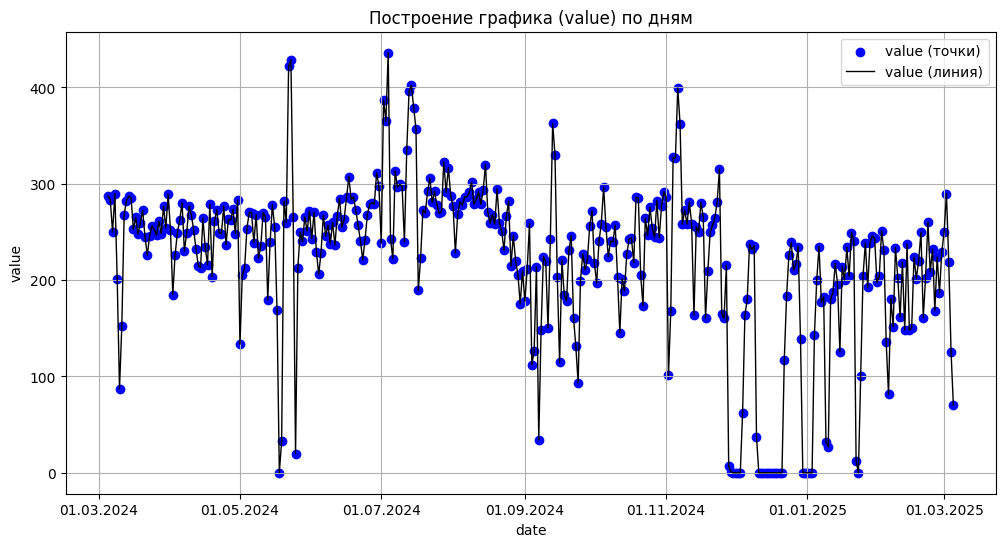

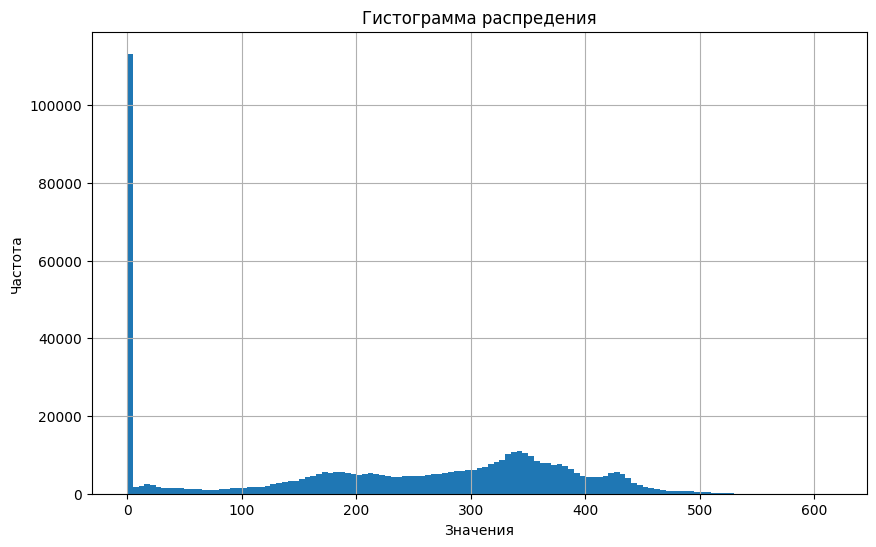

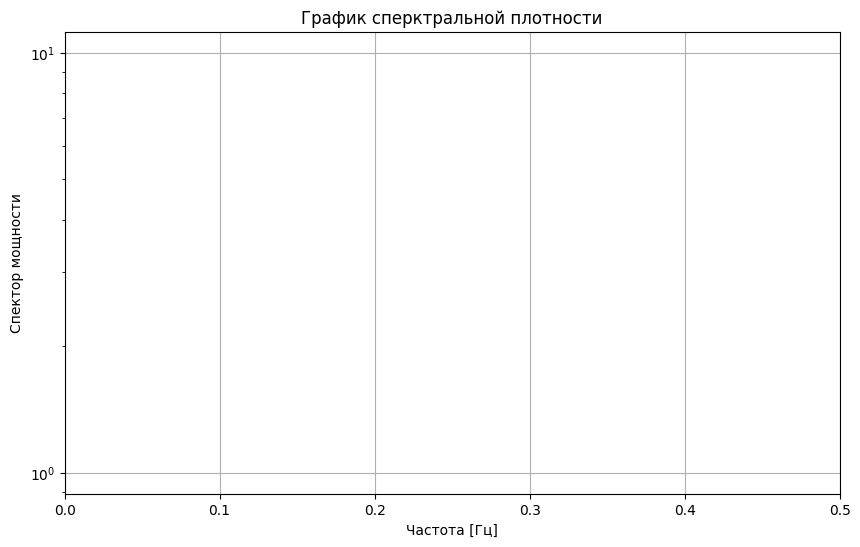

Максимальный лаг: 725


<Figure size 1000x600 with 0 Axes>

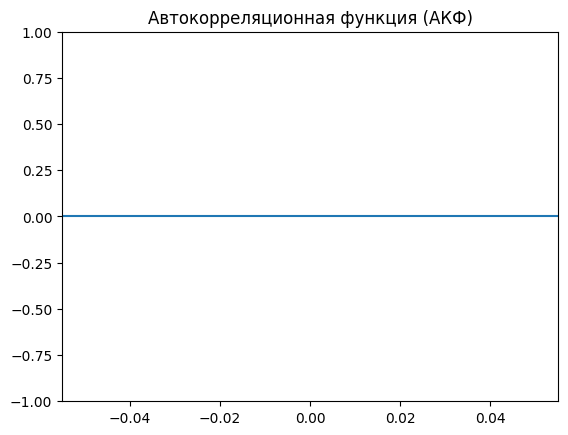

<Figure size 1000x600 with 0 Axes>

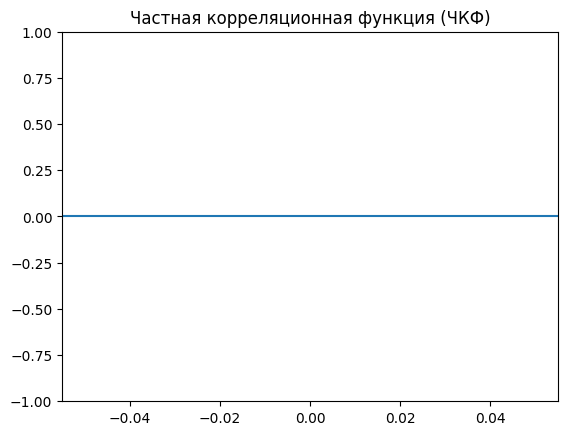

In [18]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "05.03.2024"
end_date_str = "05.03.2025"

# Преобразование строк в объекты datetime
start_date = pd.to_datetime(start_date_str, format="%d.%m.%Y")
end_date = pd.to_datetime(end_date_str, format="%d.%m.%Y")

# Фильтруем данные по дате
filtered_df = filter_by_date(result_df, start_date, end_date)

# Рассчитываем статистику
statistics = calculate_statistics(filtered_df)

# Формируем таблицу с результатами
table_headers = ['Показатель', 'Значение']
table_data = [(key, value) for key, value in statistics.items()]
table_data.extend([
    ('Квантиль 25%', statistics['Квантили'][0.25]),
    ('Квантиль 50%', statistics['Квантили'][0.5]),
    ('Квантиль 75%', statistics['Квантили'][0.75])
])
table = tabulate(table_data, headers=table_headers, tablefmt="github", floatfmt=".4f")
print('Основные статистические показатели')
print(f"период: {start_date_str} - {end_date_str}")
print("-"*77)
print(table)
print("-"*77)

# Строим график временного ряда
if start_date == end_date:
    plot_hours(filtered_df, x_column="time", y_column="value", mode="max")  # По умолчанию 'max'
else:
    plot_days(filtered_df, x_column="date", y_column="value", mode="mean")

# Строим гистограмму распределения
plot_histogram(filtered_df)

# Строим график спектральной плотности
#plot_spectral_density(result_df, start_date_str, end_date_str)
plot_spectral_density(result_df, start_date, end_date)

# Строим графики ACF и PACF
plot_acf_pacf(filtered_df)

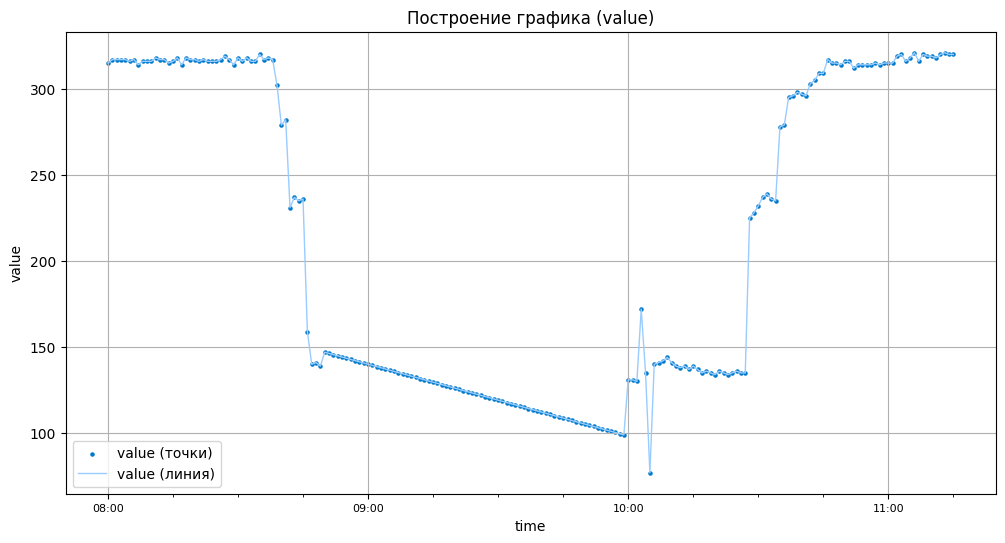

In [41]:
# Функция для фильтрации данных по дате и времени
def filter_by_date_and_time(result_df, selected_date, start_time, end_time):
    # Фильтруем данные по дате
    date_mask = result_df['date'] == selected_date
    filtered_by_date = result_df[date_mask].copy()  # Создаем явную копию

    # Преобразуем столбец time в формат времени
    filtered_by_date['time'] = pd.to_datetime(filtered_by_date['time'], format='%H:%M')

    # Фильтруем данные по времени
    time_mask = (filtered_by_date['time'] >= start_time) & (filtered_by_date['time'] <= end_time)
    filtered_by_time = filtered_by_date[time_mask]

    return filtered_by_time



# Задание даты и интервала времени
selected_date = pd.to_datetime("05.04.2024", format="%d.%m.%Y")
start_time = pd.to_datetime("08:00", format='%H:%M')
end_time = pd.to_datetime("11:15", format='%H:%M')

# Предположим, что result_df - ваш исходный датафрейм
filtered_df = filter_by_date_and_time(result_df, selected_date, start_time, end_time)

# Вызов функции построения графика
if not filtered_df.empty:
    #plot_selected_interval(filtered_df, x_column="time", y_column="value")
    plot_selected_interval(filtered_df, selected_date, x_column="время", y_column="value")
else:
    print("Нет данных для выбранного интервала времени.")

In [54]:
# Функция для расчёта основных статистик
def calculate_statistics(filtered_df, value_col):
    """ Функция для расчета основных статистик временного ряда.
    :param filtered_df: Датафрейм Pandas с временным рядом.
    :param value_col: Название колонки, содержащей данные временного ряда.
    :return: Словарь с рассчитанными статистиками. """
    statistics = {}  # Инициализация словаря для хранения статистик

    # Количество данных в выборке
    statistics['Количество данных в выборке'] = filtered_df[value_col].count()

    # Среднее арифметическое (математическое ожидание)
    statistics['Математическое ожидание'] = filtered_df[value_col].mean()

    # Медиана (центральный элемент выборки)
    statistics['Медиана'] = filtered_df[value_col].median()

    # Максимальное значение
    statistics['Максимальное значение'] = filtered_df[value_col].max()

    # Минимальное значение
    statistics['Минимальное значение'] = filtered_df[value_col].min()

    # Дисперсия (мера разброса данных вокруг среднего)
    statistics['Дисперсия'] = filtered_df[value_col].var()

    # Стандартное отклонение (корень квадратный из дисперсии)
    statistics['Среднее квадратичное отклонение'] = filtered_df[value_col].std()

    # Асимметрия (мера несимметричности распределения)
    statistics['Асимметрия'] = filtered_df[value_col].skew()

    # Эксцесс (мера остроты пика распределения)
    statistics['Эксцесс'] = filtered_df[value_col].kurtosis()

    # Квантили (25%, 50%, 75%)
    statistics['Квантили'] = filtered_df[value_col].quantile([0.25, 0.5, 0.75]).to_dict()

    # Коэффициент автокорреляции (мера линейной связи между элементами ряда)
    statistics['Коэффициент автокорреляции'] = filtered_df[value_col].autocorr(lag=1)

    values = filtered_df['value'].values
    statistics['Показатель Херста'] = calculate_hurst_exponent(values)

    return statistics  # Возврат словаря со всеми рассчитанными статистиками



def plot_histogram(filtered_df, value_col):
    """ Функция для построения гистограммы распределения значений временного ряда.
    :param filtered_df: Датафрейм Pandas с временным рядом.
    :param value_col: Название колонки, содержащей данные временного ряда. """
    plt.figure(figsize=(10, 6))  # Создание фигуры с размерами 10x6 дюймов

    # Построение гистограммы с 5-ю единичными интервалами между минимумом и максимумом значений
    plt.hist(filtered_df[value_col],
             bins=range(int(filtered_df[value_col].min()),
                        int(filtered_df[value_col].max()) + 5, 5))

    plt.title("Гистограмма распределения")  # Заголовок графика
    plt.xlabel(value_col)                  # Название оси X
    plt.ylabel("Частота")                  # Название оси Y
    plt.grid(True)                         # Включение сетки для удобства чтения графика
    plt.show()                             # Отображение графика



def plot_spectral_density(result_df, start_date, end_date, value_col):
    """ Функция для построения графика спектральной плотности мощности временного ряда.
    :param result_df: Датафрейм Pandas с временным рядом.
    :param start_date: Начальная дата фильтрации.
    :param end_date: Конечная дата фильтрации.
    :param value_col: Название колонки, содержащей данные временного ряда. """
    # Фильтрация данных по дате
    filtered_df = result_df[(result_df['date'] >= start_date) & (result_df['date'] <= end_date)]

    # Выбор временного ряда для анализа
    values = filtered_df[value_col].values

    # Параметры для оценки спектральной плотности
    fs = 1  # Частота дискретизации (здесь 1, так как это временной ряд)
    nperseg = len(values) // 2  # Размер сегмента (зависит от длины ряда)
    window = blackman(nperseg)  # Применение оконной функции Blackman

    # Оцениваем спектральную плотность мощности с помощью метода Welch
    frequencies, psd = welch(values, fs=fs, nperseg=nperseg, window=window)

    # Построение графика спектральной плотности
    plt.figure(figsize=(10, 6))
    plt.semilogy(frequencies, psd, color='b')  # Логарифмическая шкала для оси Y
    plt.xlim(0, frequencies.max())  # Ограничиваем ось X
    plt.title(f'График спектральной плотности для {value_col}')
    plt.xlabel('Частота [Гц]')
    plt.ylabel('Спектр мощности')
    plt.grid(True)
    plt.autoscale(enable=True, axis='both', tight=None)  # Автоматическое масштабирование осей
    plt.show()



def plot_acf_pacf(filtered_df, value_col):
    """ Функция для построения графиков автокорреляционной функции (ACF) и частной автокорреляционной функции (PACF). :param filtered_df: Датафрейм Pandas с временным рядом. :param value_col: Название колонки, содержащей данные временного ряда. """
    n = len(filtered_df[value_col])
    max_lags = int(np.sqrt(n))  # Подбор количества лагов согласно правилу Бартлетта

    print(f"Максимальный лаг: {max_lags}")

    plt.figure(figsize=(10, 6))
    plot_acf(filtered_df[value_col], lags=max_lags, title='Автокорреляционная функция (АКФ)', zero=False)
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(filtered_df[value_col], lags=max_lags, title='Частная корреляционная функция (ЧКФ)', zero=False)
    plt.show()

In [22]:
def analyze_timeseries(result_df, start_date_str, end_date_str, value_col):
    """ Функция для анализа временного ряда.
    :param result_df: Датафрейм Pandas с временным рядом.
    :param start_date_str: Начальная дата в формате 'DD.MM.YYYY'.
    :param end_date_str: Конечная дата в формате 'DD.MM.YYYY'.
    :param value_col: Название колонки, содержащей данные временного ряда. """

    # Преобразование строк в объекты datetime
    start_date = pd.to_datetime(start_date_str, format="%d.%m.%Y")
    end_date = pd.to_datetime(end_date_str, format="%d.%m.%Y")

    # Фильтруем данные по дате
    filtered_df = filter_by_date(result_df, start_date, end_date)

    # Рассчитываем статистику
    statistics = calculate_statistics(filtered_df, value_col)

    # Формируем таблицу с результатами
    table_headers = ['Показатель', 'Значение']
    table_data = [(key, value) for key, value in statistics.items()]
    table_data.extend([
        ('Квантиль 25%', statistics['Квантили'][0.25]),
        ('Квантиль 50%', statistics['Квантили'][0.5]),
        ('Квантиль 75%', statistics['Квантили'][0.75])
    ])
    table = tabulate(table_data, headers=table_headers, tablefmt="github", floatfmt=".4f")
    print('Основные статистические показатели')
    print(f"период: {start_date_str} - {end_date_str}")
    print("-"*77)
    print(table)
    print("-"*77)

    # Строим график временного ряда
    if start_date == end_date:
        plot_hours(filtered_df, x_column="time", y_column=value_col, mode="max")  # По умолчанию 'max'
    else:
        plot_days(filtered_df, x_column="date", y_column=value_col, mode="mean")

    # Строим гистограмму распределения
    plot_histogram(filtered_df, value_col)

    # Строим график спектральной плотности
    plot_spectral_density(result_df, start_date, end_date, value_col)

    # Строим графики ACF и PACF
    plot_acf_pacf(filtered_df, value_col)

# Статистический анализ

# **1. Полный диапазон ВР**

Основные статистические показатели
период: 05.03.2024 - 05.03.2025
-----------------------------------------------------------------------------
| Показатель                      | Значение                                                        |
|---------------------------------|-----------------------------------------------------------------|
| Количество данных в выборке     | 526316                                                          |
| Математическое ожидание         | 221.40897103641157                                              |
| Медиана                         | 251.4487756121939                                               |
| Максимальное значение           | 615.0                                                           |
| Минимальное значение            | 0.0                                                             |
| Дисперсия                       | 22771.366375731774                                              |
| Среднее квадратичное отклонение | 150

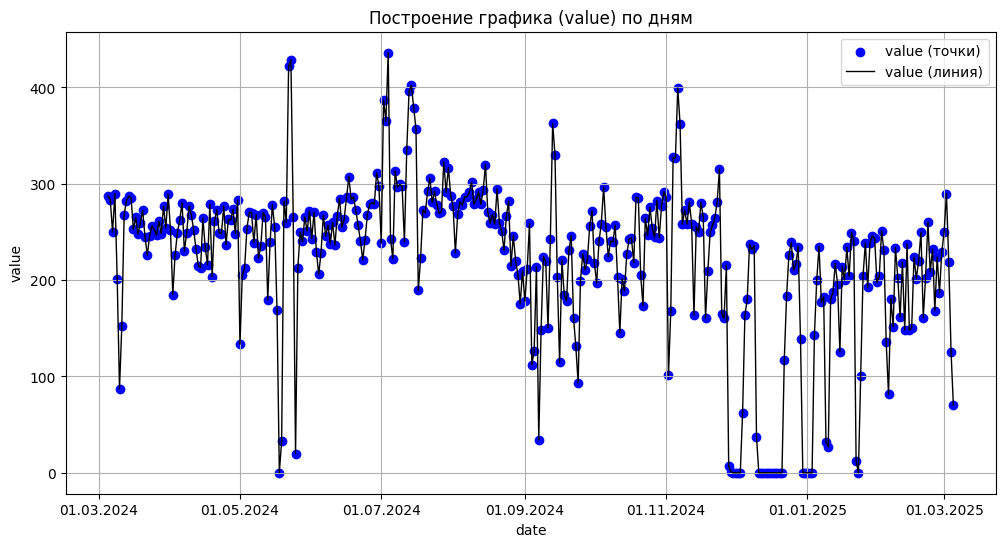

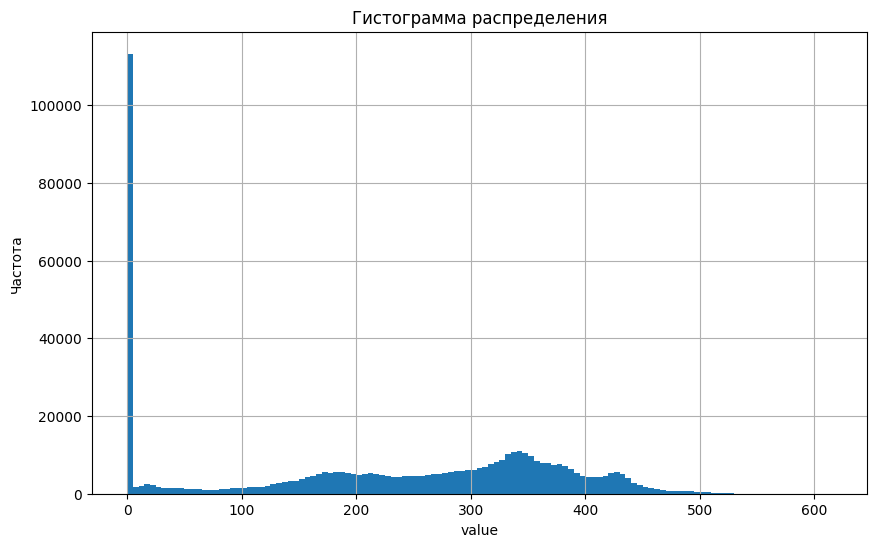

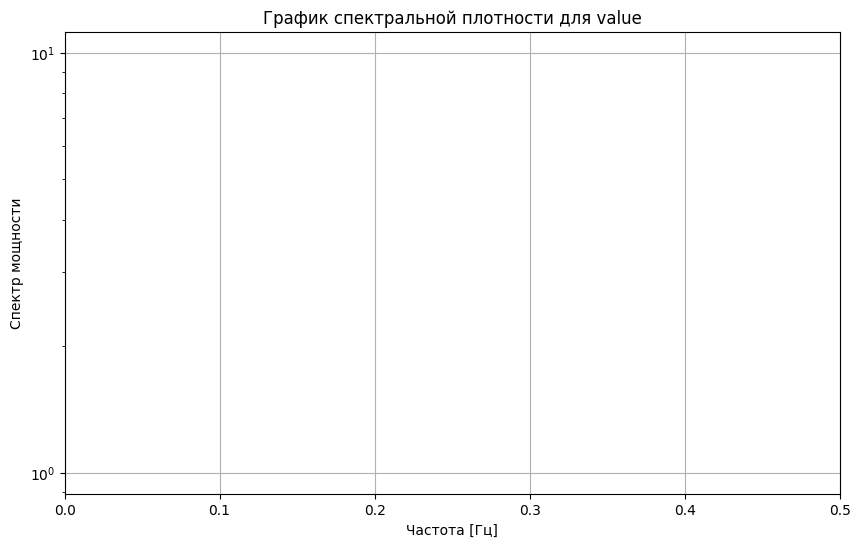

Максимальный лаг: 725


<Figure size 1000x600 with 0 Axes>

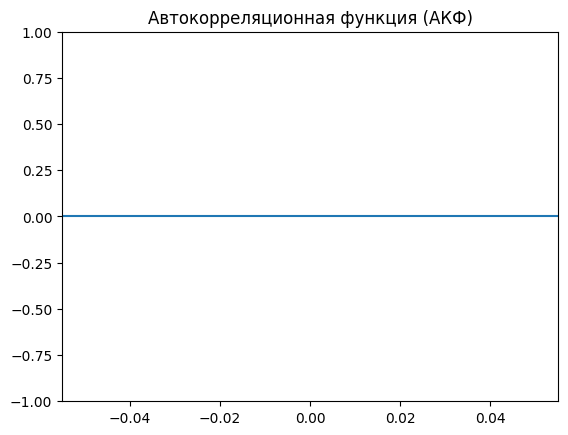

<Figure size 1000x600 with 0 Axes>

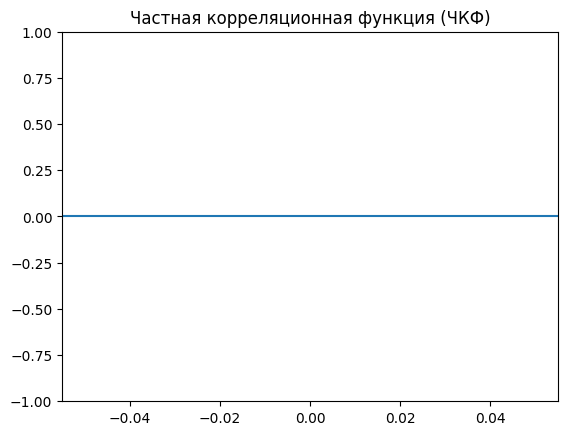

In [55]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "05.03.2024"
end_date_str = "05.03.2025"

# Название колонки с данными временного ряда
value_col = "value"

# Предположим, что result_df - ваш исходный датафрейм
analyze_timeseries(result_df, start_date_str, end_date_str, value_col)

**2. Период - месяц (июнь 2024)**

Основные статистические показатели
период: 01.06.2024 - 30.06.2024
-----------------------------------------------------------------------------
| Показатель                      | Значение                                            |
|---------------------------------|-----------------------------------------------------|
| Количество данных в выборке     | 43200                                               |
| Математическое ожидание         | 262.1020486111111                                   |
| Медиана                         | 280.0                                               |
| Максимальное значение           | 470.0                                               |
| Минимальное значение            | 0.0                                                 |
| Дисперсия                       | 8973.522329041467                                   |
| Среднее квадратичное отклонение | 94.72867743741315                                   |
| Асимметрия                      | -0.728697

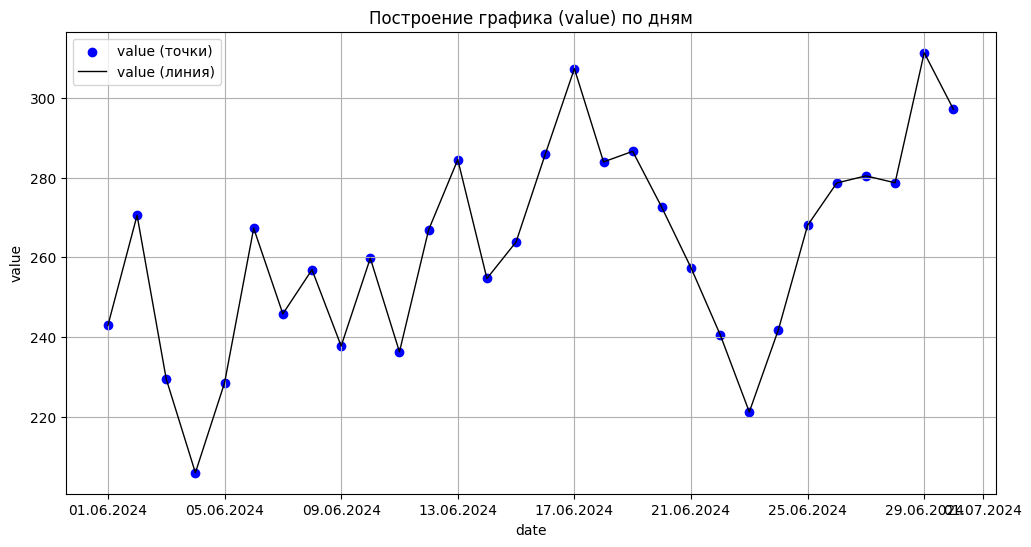

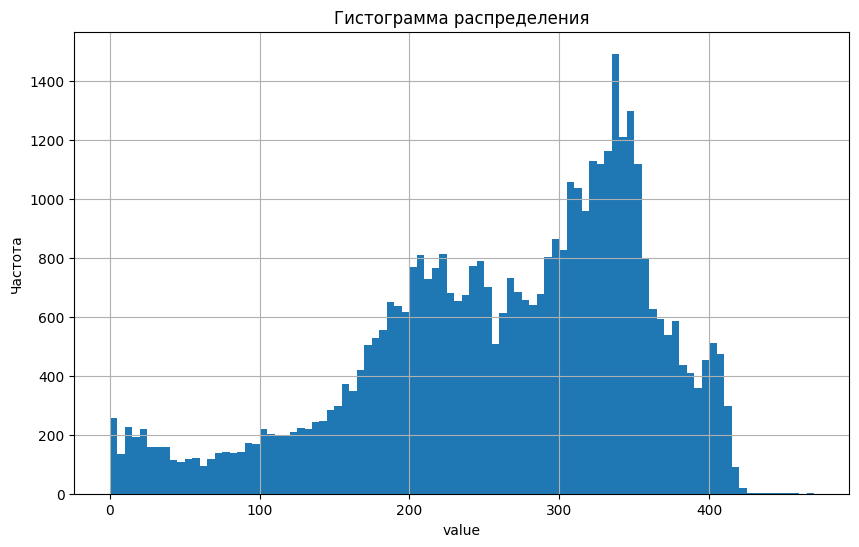

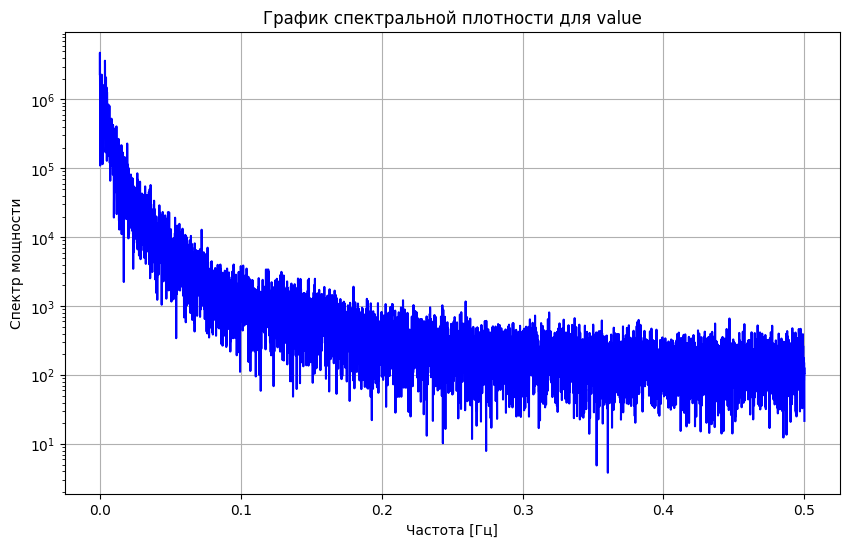

Максимальный лаг: 207


<Figure size 1000x600 with 0 Axes>

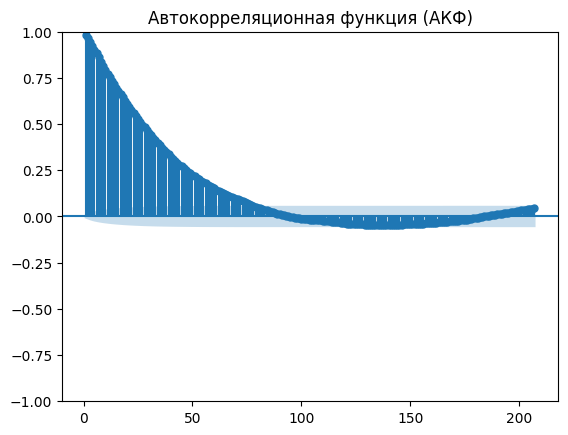

<Figure size 1000x600 with 0 Axes>

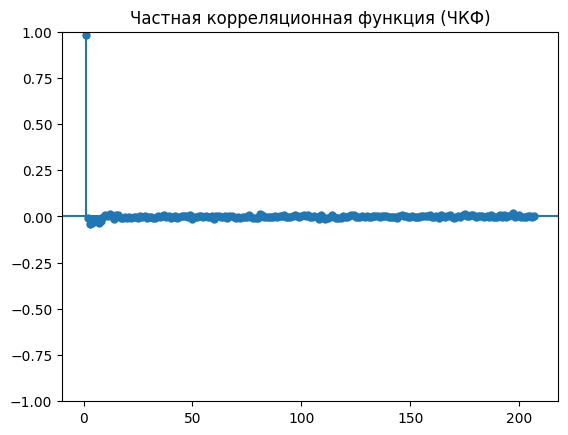

In [56]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "01.06.2024"
end_date_str = "30.06.2024"

# Название колонки с данными временного ряда
value_col = "value"

# Предположим, что result_df - ваш исходный датафрейм
analyze_timeseries(result_df, start_date_str, end_date_str, value_col)

3.  Период - 1 неделя (14.10.2024 - 20.10.2024)

Основные статистические показатели
период: 14.10.2024 - 20.10.2024
-----------------------------------------------------------------------------
| Показатель                      | Значение                               |
|---------------------------------|----------------------------------------|
| Количество данных в выборке     | 10080                                  |
| Математическое ожидание         | 241.62683531746032                     |
| Медиана                         | 245.0                                  |
| Максимальное значение           | 479.0                                  |
| Минимальное значение            | 0.0                                    |
| Дисперсия                       | 22767.603293089804                     |
| Среднее квадратичное отклонение | 150.88937435449125                     |
| Асимметрия                      | -0.3294130355541172                    |
| Эксцесс                         | -1.08897987060751                      |
| Кванти

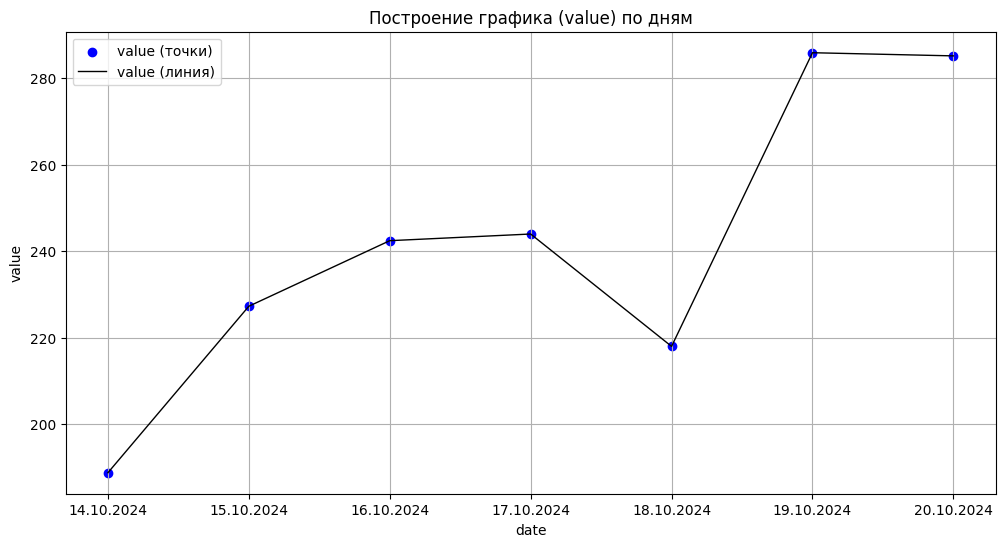

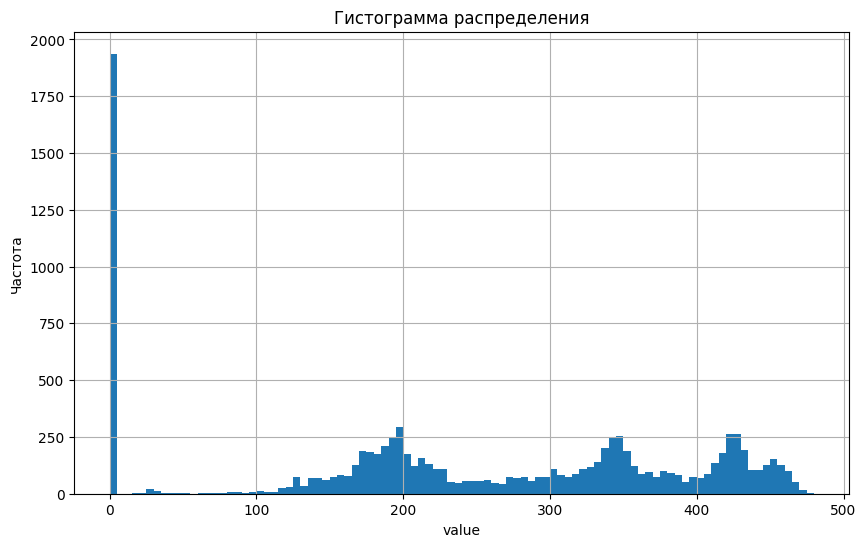

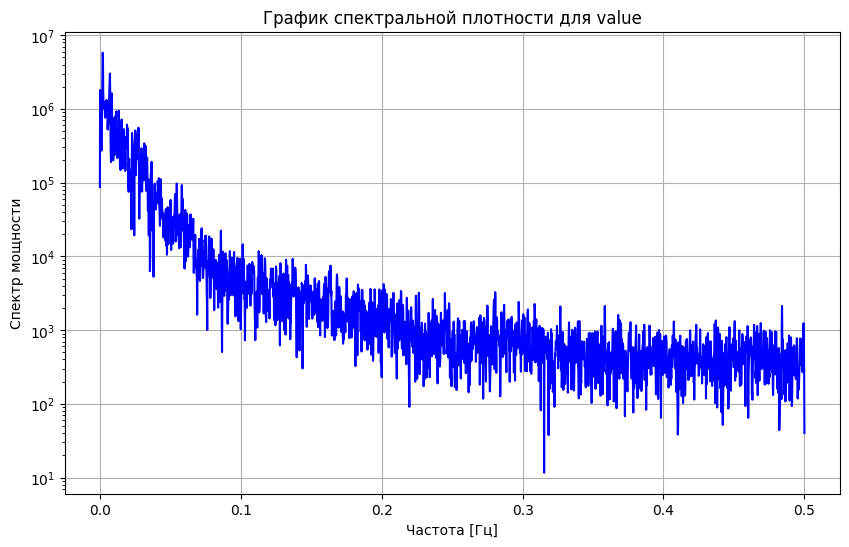

Максимальный лаг: 100


<Figure size 1000x600 with 0 Axes>

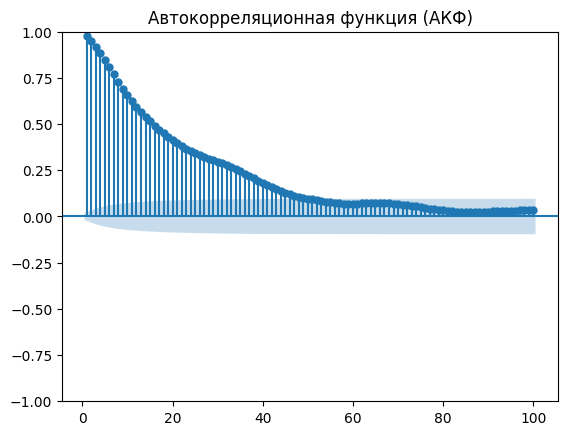

<Figure size 1000x600 with 0 Axes>

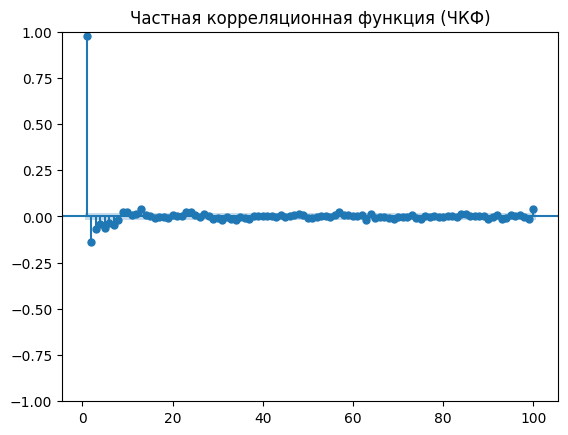

In [57]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "14.10.2024"
end_date_str = "20.10.2024"

# Название колонки с данными временного ряда
value_col = "value"

# Предположим, что result_df - ваш исходный датафрейм
analyze_timeseries(result_df, start_date_str, end_date_str, value_col)

**4. Период - 1 день (20.02.2025)**

Основные статистические показатели
период: 20.02.2025 - 20.02.2025
-----------------------------------------------------------------------------
| Показатель                      | Значение                             |
|---------------------------------|--------------------------------------|
| Количество данных в выборке     | 1440                                 |
| Математическое ожидание         | 161.0548611111111                    |
| Медиана                         | 205.0                                |
| Максимальное значение           | 339.0                                |
| Минимальное значение            | 0.0                                  |
| Дисперсия                       | 21535.773569125944                   |
| Среднее квадратичное отклонение | 146.75071914347112                   |
| Асимметрия                      | -0.05562358441557227                 |
| Эксцесс                         | -1.826278554312938                   |
| Квантили                    

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


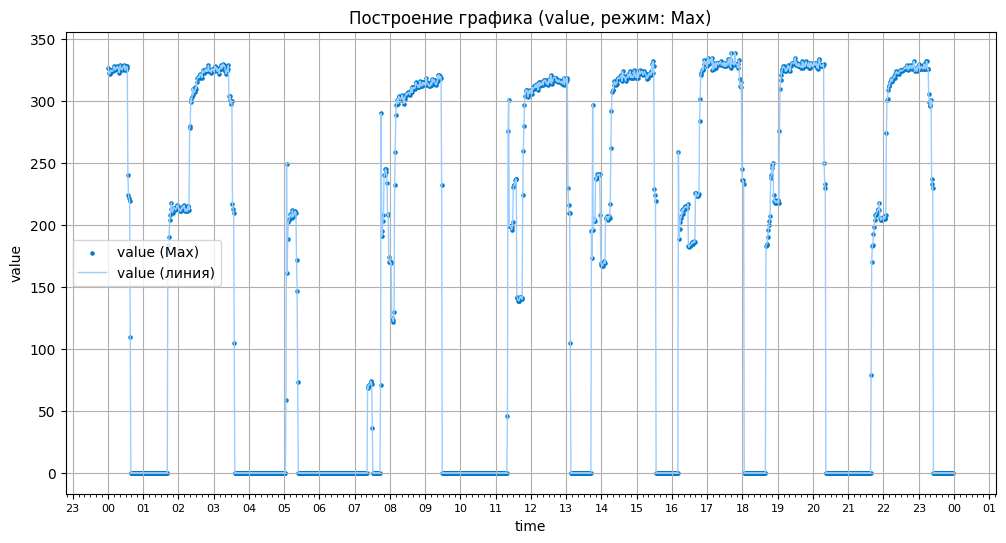

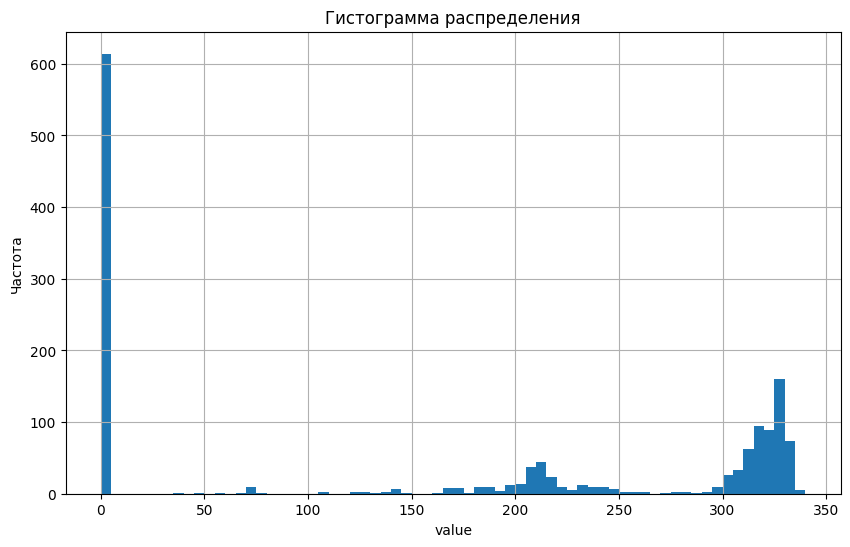

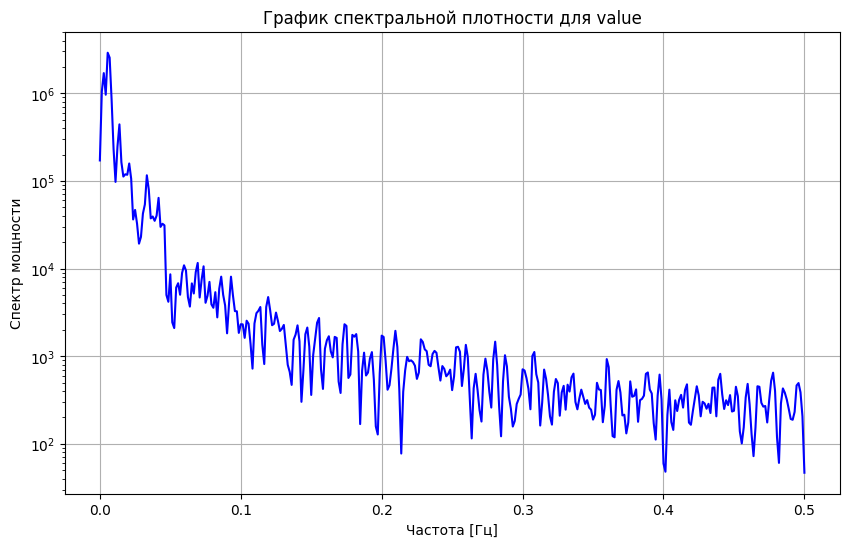

Максимальный лаг: 37


<Figure size 1000x600 with 0 Axes>

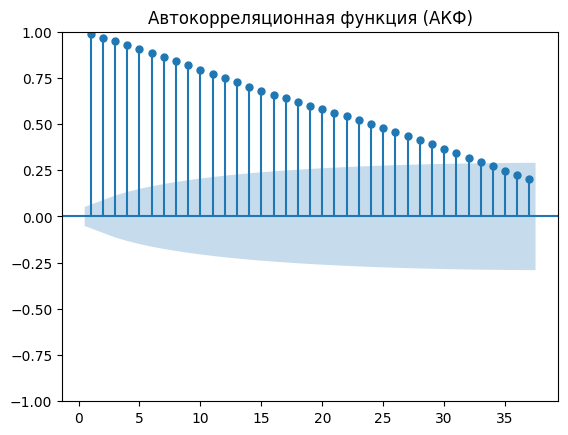

<Figure size 1000x600 with 0 Axes>

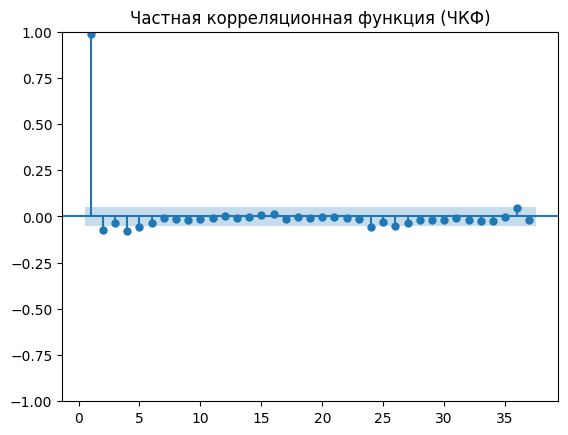

In [58]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "20.02.2025"
end_date_str = "20.02.2025"

# Название колонки с данными временного ряда
value_col = "value"

# Предположим, что result_df - ваш исходный датафрейм
analyze_timeseries(result_df, start_date_str, end_date_str, value_col)

4.1. Дополнительно размернули график ВР отдельные периоды суток 20.02.2025

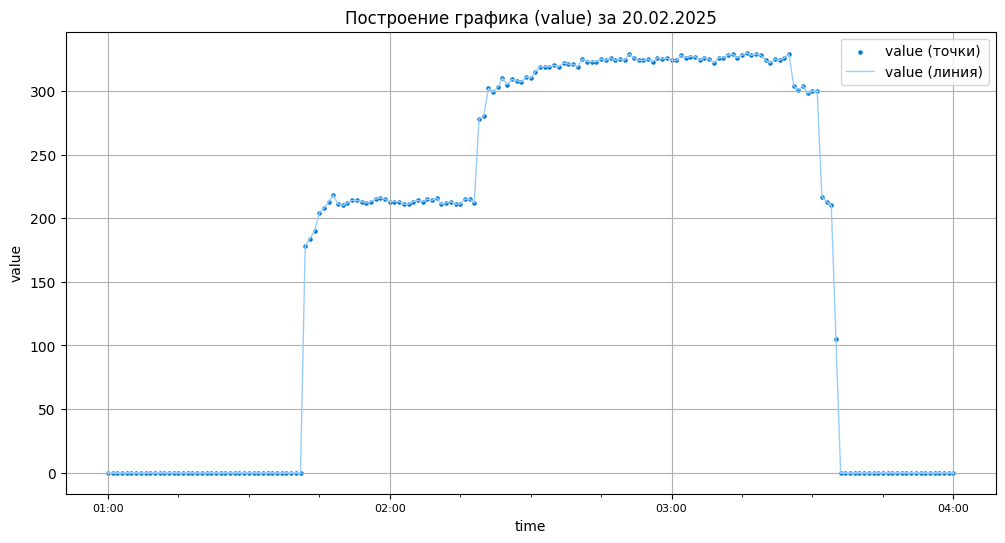

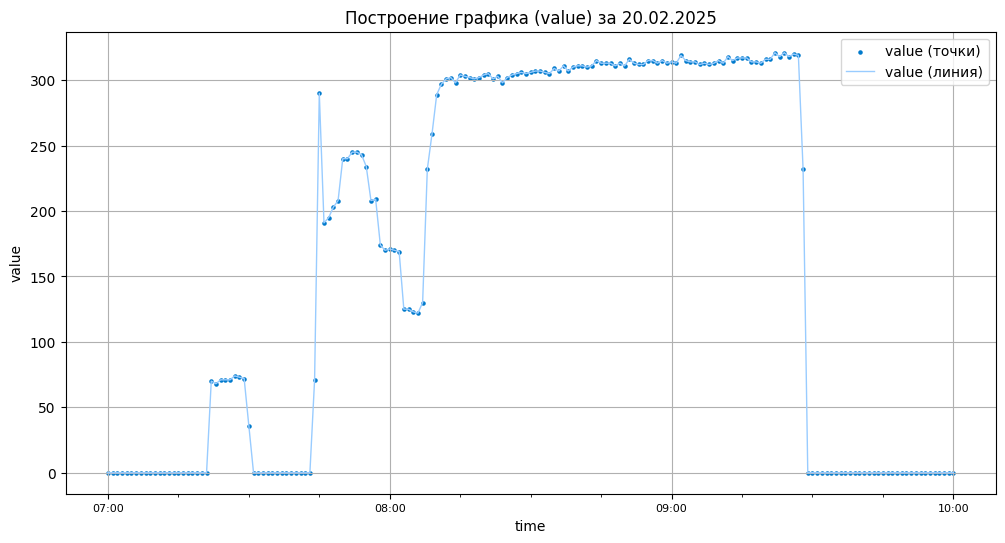

20.02.2025


In [59]:
# Задание даты и интервала времени
selected_date = pd.to_datetime("20.02.2025", format="%d.%m.%Y")
start_time = pd.to_datetime("01:00", format='%H:%M')
end_time = pd.to_datetime("04:00", format='%H:%M')
selected_date_str = selected_date.strftime("%d.%m.%Y")

# Предположим, что result_df - ваш исходный датафрейм
filtered_df = filter_by_date_and_time(result_df, selected_date, start_time, end_time)

# Вызов функции построения графика
if not filtered_df.empty:
    plot_selected_interval(filtered_df,  selected_date_str, x_column="time", y_column="value")
else:
    print("Нет данных для выбранного интервала времени.")


start_time = pd.to_datetime("07:00", format='%H:%M')
end_time = pd.to_datetime("10:00", format='%H:%M')

# Предположим, что result_df - ваш исходный датафрейм
filtered_df = filter_by_date_and_time(result_df, selected_date, start_time, end_time)

# Вызов функции построения графика
if not filtered_df.empty:
    plot_selected_interval(filtered_df, selected_date_str, x_column="time", y_column="value")
else:
    print("Нет данных для выбранного интервала времени.")
print(selected_date_str)

5. Период с 14.05.2024 по 27.05.2024 (резкие скачки)

Основные статистические показатели
период: 14.05.2024 - 27.05.2024
-----------------------------------------------------------------------------
| Показатель                      | Значение                                             |
|---------------------------------|------------------------------------------------------|
| Количество данных в выборке     | 20160                                                |
| Математическое ожидание         | 222.53586309523808                                   |
| Медиана                         | 224.525                                              |
| Максимальное значение           | 592.0                                                |
| Минимальное значение            | 0.0                                                  |
| Дисперсия                       | 30580.89817844835                                    |
| Среднее квадратичное отклонение | 174.8739493991268                                    |
| Асимметрия                      | 

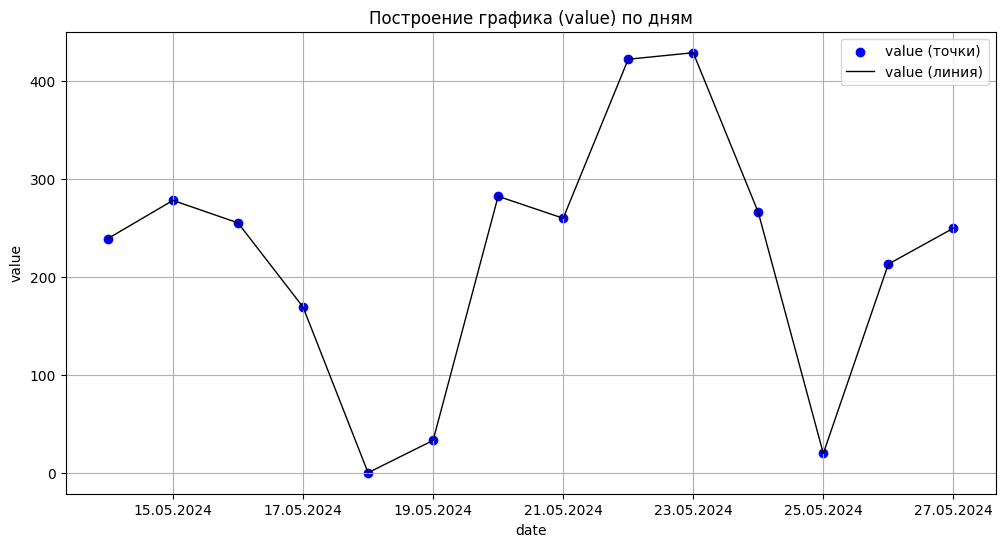

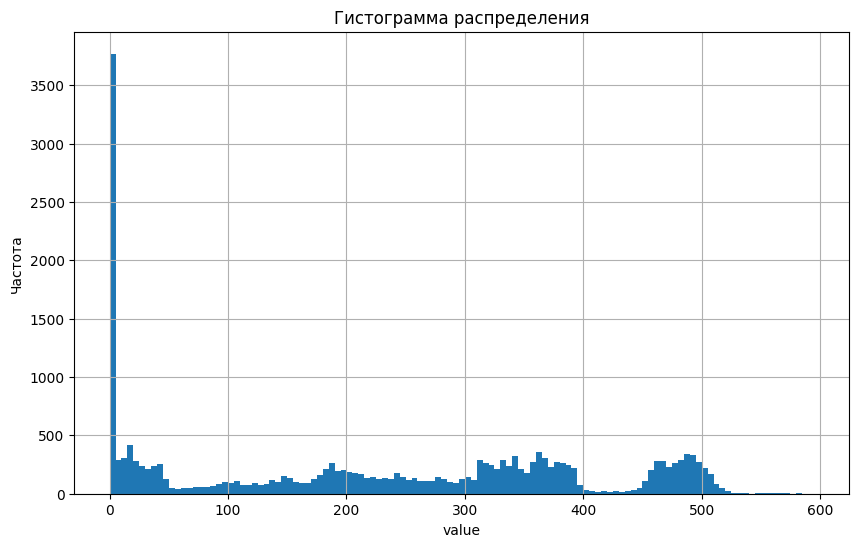

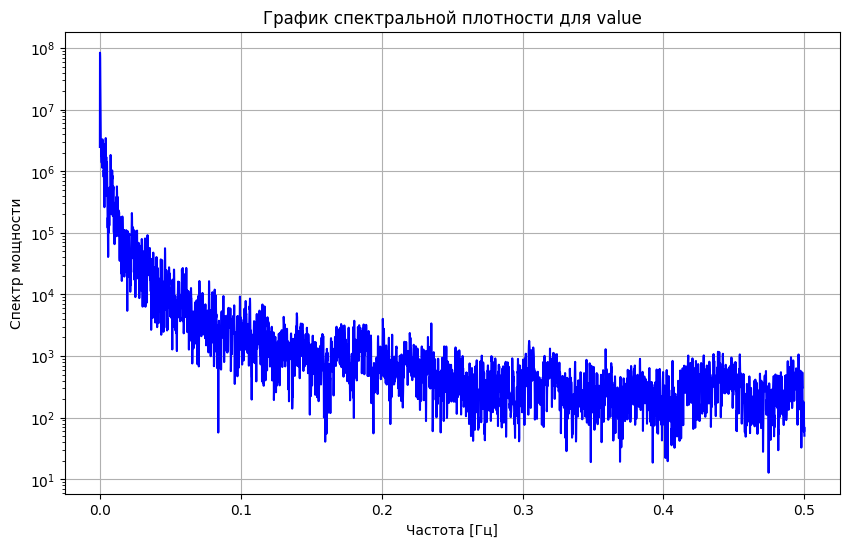

Максимальный лаг: 141


<Figure size 1000x600 with 0 Axes>

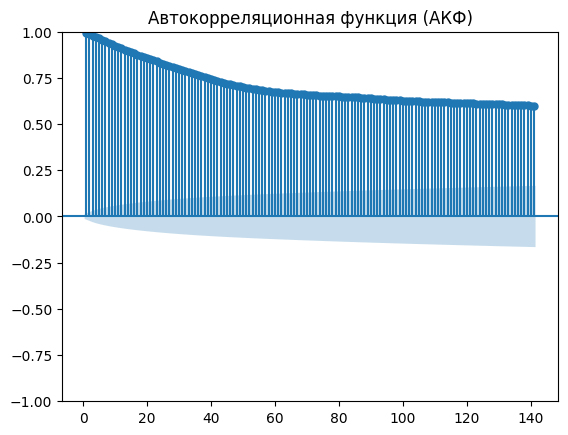

<Figure size 1000x600 with 0 Axes>

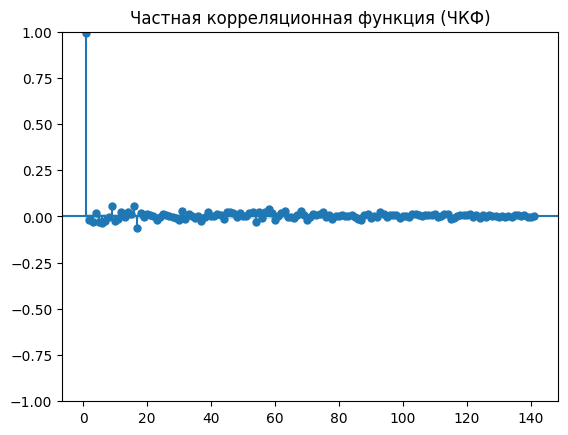

In [60]:
# Задание дат в формате DD.MM.YYYY
start_date_str = "14.05.2024"
end_date_str = "27.05.2024"

# Название колонки с данными временного ряда
value_col = "value"

# Предположим, что result_df - ваш исходный датафрейм
analyze_timeseries(result_df, start_date_str, end_date_str, value_col)

5.1. Детализация за 24.05.2024 с 16:45 до 20:15

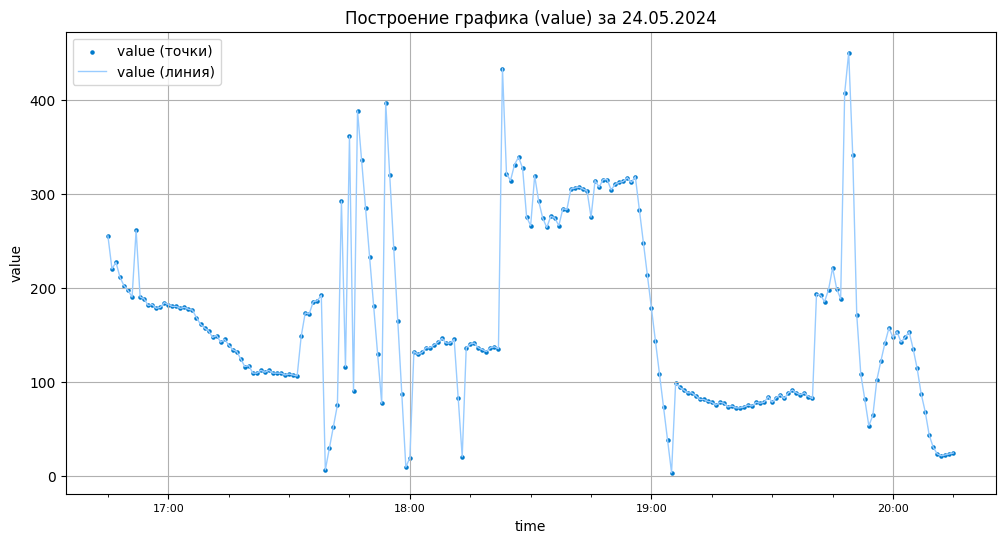

In [61]:
# Задание даты и интервала времени
selected_date = pd.to_datetime("24.05.2024", format="%d.%m.%Y")
start_time = pd.to_datetime("16:45", format='%H:%M')
end_time = pd.to_datetime("20:15", format='%H:%M')
selected_date_str = selected_date.strftime("%d.%m.%Y")

# Предположим, что result_df - ваш исходный датафрейм
filtered_df = filter_by_date_and_time(result_df, selected_date, start_time, end_time)

# Вызов функции построения графика
if not filtered_df.empty:
    plot_selected_interval(filtered_df,  selected_date_str, x_column="time", y_column="value")
else:
    print("Нет данных для выбранного интервала времени.")

In [70]:
import pandas as pd
import numpy as np
from scipy.signal import welch

def calculate_psd_metrics(dataset, date_column, value_column, start_date, end_date):
    """ Функция для расчета интегральных показателей спектральной плотности мощности (PSD). :param dataset: Датафрейм Pandas с временным рядом. :param date_column: Название колонки, содержащей даты. :param value_column: Название колонки, содержащей данные временного ряда. :param start_date: Начальная дата периода в формате 'YYYY-MM-DD'. :param end_date: Конечная дата периода в формате 'YYYY-MM-DD'. :return: Словарь с рассчитанными показателями. """
    # Фильтрация данных по дате
    filtered_df = dataset[(dataset[date_column] >= start_date) & (dataset[date_column] <= end_date)]

    # Выбор временного ряда для анализа
    values = filtered_df[value_column].values

    # Параметры для оценки спектральной плотности
    fs = 1  # Частота дискретизации (здесь 1, так как это временной ряд)
    nperseg = len(values) // 2  # Размер сегмента (зависит от длины ряда)
    window = 'blackman'  # Применение оконной функции Blackman

    # Оцениваем спектральную плотность мощности с помощью метода Welch
    frequencies, psd = welch(values, fs=fs, nperseg=nperseg, window=window)

    # Расчет интегральных показателей
    dfreq = np.diff(frequencies)  # Разница между соседними частотами
    total_energy = np.sum(psd[:-1] * dfreq)  # Общая энергия сигнала

    # Энергия в низкочастотной полосе (до 10 Гц)
    low_freq_mask = (frequencies[:-1] >= 0) & (frequencies[:-1] <= 10)
    low_freq_energy = np.sum(psd[:-1][low_freq_mask] * dfreq[low_freq_mask])

    # Доминирующая частота
    dominant_frequency = frequencies[np.argmax(psd)]

    # Средний уровень мощности
    avg_power = np.mean(psd)

    # Ширина полосы пропускания (например, 90% энергии)
    cumulative_energy = np.cumsum(psd[:-1] * dfreq)
    threshold = 0.9 * total_energy  # Порог 90% энергии
    bandwidth_index = np.searchsorted(cumulative_energy, threshold)
    bandwidth = frequencies[bandwidth_index] - frequencies[0]

    # Возвращаем словарь с рассчитанными показателями
    metrics = {
        'Total Energy': total_energy,
        'Low Frequency Energy (<10 Hz)': low_freq_energy,
        'Dominant Frequency': dominant_frequency,
        'Average Power': avg_power,
        'Bandwidth (90%)': bandwidth
    }

    return metrics

# Пример использования функции
#dataset = pd.read_csv('your_dataset.csv', parse_dates=['date_column'])  # Читаем CSV файл с датасетом
#metrics = calculate_psd_metrics(dataset, 'date_column', 'value_column', '2023-01-01', '2023-12-31')
metrics = calculate_psd_metrics(result_df, 'date', 'value', '2024-05-01', '2024-05-20')

print(metrics)

# Преобразование результатов в DataFrame и вывод в таблицу
pd.set_option('display.max_columns', None)  # Показывать все столбцы
print(pd.DataFrame.from_dict(metrics, orient='index'))

{'Total Energy': 11426.050534826643, 'Low Frequency Energy (<10 Hz)': 11426.050534826643, 'Dominant Frequency': 0.0001388888888888889, 'Average Power': 22848.92953605077, 'Bandwidth (90%)': 0.01513888888888889}
                                          0
Total Energy                   11426.050535
Low Frequency Energy (<10 Hz)  11426.050535
Dominant Frequency                 0.000139
Average Power                  22848.929536
Bandwidth (90%)                    0.015139
